# Atividade prática 1

### Bibliotecas necessárias

In [12]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import scienceplots

In [13]:
# Configuração do estilo dos plots
plt.style.use(['science', 'notebook', 'grid'])

---

## Funções necessárias

### Inicialização

Para evitar que haja soluções ruins no conjunto inicial de soluções, utiliza-se a representação na forma de permutações. Cada solução é um vetor de comprimento 4 cujos elementos são uma permutação de [1,2,3,4]. O índice do vetor corresponde à coluna em que cada rainha se localiza, enquanto o valor armazenado nesse índice corresponde à linha dessa coluna em que a rainha está.

In [14]:
# Inicializa a população
#
# _mu --> número de indivíduos na população (soluções candidatas)
# n --> cada indivíduo vai ser um tabuleiro nxn com n rainhas
def init_population(_mu:int = 20, n:int = 8):
    population = []
    for i in range (_mu):
        population.append(rd.sample(range(n), n))
    return np.array(population)


---

### Avaliação dos indivíduos da população

Como a definição do genótipo dos indivíduos impede que haja rainhas na mesma linha ou na mesma coluna, para avaliar a aptidão de um indivíduo basta contar o número de rainhas que estão na mesma diagonal.

In [15]:
# Aptidão de um indivíduo (número de xeques para uma solução candidata)
def fitness_nq(solution):
    xeques = 0
    for i in range(0,len(solution)):
        for j in range(0,len(solution)):
            if i!=j:
                if i-solution[i] == j-solution[j] or i+solution[i] == j+solution[j]:
                    xeques+=1
    return xeques


---

### Seleção dos pais

Para gerar a próxima população, é necessário selecionar quais indivíduos serão combinados para gerar descendentes. Nesta implementação, serão amostrados 5 invidíduos da população original aleatoriamente e os 2 mais aptos serão selecionados para gerar descendentes.

In [16]:
def seleciona_pais(pop):
    pop_fitness = np.array([fitness_nq(solution) for solution in pop])
    fitness_indexado = np.array([[i,j] for (i,j) in zip(range(len(pop_fitness)), pop_fitness)])
    pais_possiveis = fitness_indexado[rd.sample(list(fitness_indexado[:, 0]), 5)]
    pais_escolhidos = pop[pais_possiveis[pais_possiveis[:, 1].argsort()][0:2,0]]
    return(pais_escolhidos)

---

### Variação dos indivíduos para criação de nova população

De forma a possibilitar a exploração do espaço de soluções possíveis, (1) faz-se a troca de informações (crossing-over) entre indivíduos da população original e (2) cria-se mutações nos indivíduos da nova população.

- Crossing-over

In [17]:
# As novas soluções candidatas devem ser permutações válidas de inteiros
def cut_and_crossfill(pais_escolhidos, cross_rate=1.0):
    r = rd.random()
    if r < cross_rate:
        pai_1 = pais_escolhidos[0]
        pai_2 = pais_escolhidos[1]
        cross_point = int(1 + np.array(rd.sample(range(len(pai_1)-1),1)))

        filho_1_inicio = pai_1[0:cross_point]
        filho_1_fim = np.array([i for i in pai_2 if not(i in filho_1_inicio)])
        filho_1 = list(np.concatenate([filho_1_inicio, filho_1_fim]))

        filho_2_inicio = pai_2[0:cross_point]
        filho_2_fim = np.array([i for i in pai_1 if not(i in filho_2_inicio)])
        filho_2 = list(np.concatenate([filho_2_inicio, filho_2_fim]))
    else:
        filho_1 = pai_1
        filho_2 = pai_2

    return(np.array([filho_1,filho_2]))

- Mutação

In [18]:
# Em um indivíduo, seleciona-se duas posições aleatórias e troca os valores nessas posições
def mutacao(individuo, mutation_rate=0.8):
    r = rd.random()
    if r < mutation_rate:
        individuo = individuo.copy()
        genes = rd.sample(range(len(individuo)), 2)
        individuo[genes[0]], individuo[genes[1]] = individuo[genes[1]], individuo[genes[0]]
    return(individuo)


---

### Seleção dos mais aptos

Gerada uma nova população (população anterior + 2 descendentes), calcula-se novamente a aptidão dos indivíduos e elimina-se os dois indivíduos menos aptos.

In [19]:
def seleciona_aptos(pop, pop_fitness):
    pop = pop.copy()
    fitness_indexado = np.array([[i,j] for (i,j) in zip(range(len(pop_fitness)), pop_fitness)])
    pop = pop[fitness_indexado[fitness_indexado[:,1].argsort()][0:-2,0]]
    return(pop)

---

## Simulação

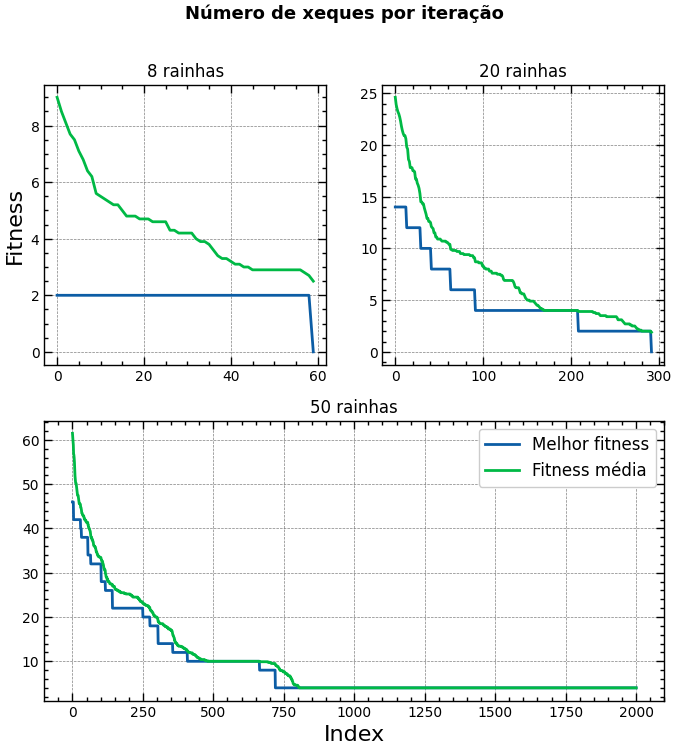

In [20]:
Nvec = [8, 20, 50]
plt.figure(figsize=(8,8))
plt.suptitle('Número de xeques por iteração', size=13, fontweight='semibold')

for index, N in enumerate(Nvec):
    crossover_rate = 1
    mutation_rate = 0.8 

    # Geração da população inicial
    pop = init_population(20, N)

    # Avaliação de dos membros da população inicial
    pop_fitness = np.array([fitness_nq(solution) for solution in pop])

    # Melhor solução na população original
    solMelhorVec = np.min(pop_fitness)
    solMediaVec = np.mean(pop_fitness)

    maxiter = 2000
    sol_otima = False
    niter = 0

    while(niter < maxiter and sol_otima==False):
        
        # Seleção dos melhores pais
        pais_escolhidos = seleciona_pais(pop)
        
        # Recombinação dos pais escolhidos para gerar 2 descendentes
        filhos = cut_and_crossfill(pais_escolhidos, crossover_rate)
        
        # Mutação (ou não) dos indivíduos da população
        filhos = np.array([mutacao(individuo) for individuo in filhos])
        pop = np.concatenate([pop, filhos])
        
        # Avaliação da nova população
        pop_fitness = np.array([fitness_nq(solution) for solution in pop])
        
        # Seleção dos indivíduos mais aptos
        pop = seleciona_aptos(pop, pop_fitness)
        
        # Avaliação da população
        pop_fitness = np.array([fitness_nq(solution) for solution in pop])
        
        melhor_fitness = np.min(pop_fitness)
        media_fitness = np.mean(pop_fitness)
        # Prepara plot dos resultados ao longo do tempo
        solMelhorVec = np.append(solMelhorVec, melhor_fitness)
        solMediaVec = np.append(solMediaVec, media_fitness)
        
        # Analisa se a solução ótima foi alcançada
        if melhor_fitness == 0:
            sol_otima = True
            
        niter += 1
        
    if index%2:
        ax.set_ylabel('Fitness')
    
    if index == 0 or index == 1:
        ax = plt.subplot(2, 2, index+1)
        ax.set_title(f'{N} rainhas', size=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.plot(solMelhorVec)
        ax.plot(solMediaVec)
    else: 
        ax = plt.subplot(2, 1, 2)
        ax.set_title(f'{N} rainhas', size=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.plot(solMelhorVec)
        ax.plot(solMediaVec)
        ax.legend(labels=['Melhor fitness', 'Fitness média'], fontsize=12)
        ax.set_xlabel('Index')

plt.show()

---

### Análise dos resultados

- #### N = 8

Para um tabuleiro com 8 rainhas, foi observada uma rápida (e monotonicamente decrescente) convergência das soluções para o valor ótimo, zero xeques. Observa-se que a aptidão da melhor solução apresenta patamares, que poderiam levar a simulação a se prender em um mínimo global e atingir o número máximo de iterações antes de atingir a solução ótima caso não houvesse um mecanismo de exploração do espaço de soluções possíveis, como a mutação.

- #### N = 20 ou N = 50

Para um tabuleiro com mais de 20 rainhas, observa-se uma rápida convergência das soluções para um mínimo local (geralmente, um número de xeques próximo de 2), que, em alguns casos, impede o sistema de atingir o mínimo global. Possíveis formas de contornar este problema são (1) aumentar a probabilidade de ocorrência de uma mutação, que favoreceria a variabilidade das soluções e evitaria que a convergência para um mínimo local ocorresse com frequência ou (2) aumentar o número máximo de iterações, que aumentaria a chance de uma mutação significativa ocorrer.
